In [3]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [4]:
img, label = mnist[0]
print('Label: ', label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


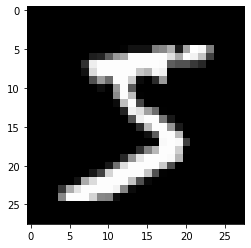

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [7]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([9, 9, 0, 4, 0, 6, 9, 1, 6, 5, 8, 7, 0, 3, 4, 0, 2, 0, 3, 0, 8, 6, 8, 7,
        5, 5, 4, 8, 9, 4, 5, 0, 5, 3, 8, 5, 8, 3, 9, 0, 0, 8, 9, 3, 1, 9, 6, 7,
        7, 2, 9, 7, 6, 7, 5, 4, 7, 1, 6, 4, 2, 4, 2, 1, 7, 5, 9, 7, 8, 8, 7, 8,
        3, 2, 9, 7, 2, 1, 1, 3, 2, 4, 7, 5, 2, 3, 3, 7, 3, 6, 1, 4, 9, 2, 0, 1,
        0, 7, 7, 2])


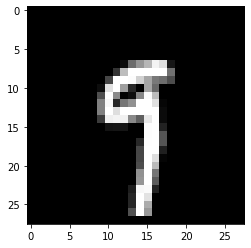

In [9]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [10]:
# Device configuration
device = torch.device('mps' if torch.has_mps else 'cpu')
device

device(type='mps')

In [11]:
image_size = 784
hidden_size = 256

In [12]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [13]:
D.to(device);

In [14]:
latent_size = 64

In [15]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [16]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

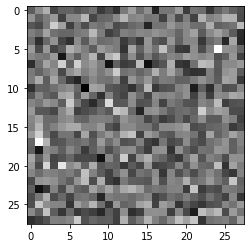

In [17]:
plt.imshow(gen_imgs[0], cmap='gray');

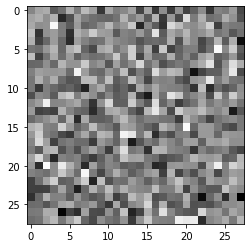

In [18]:
plt.imshow(gen_imgs[1], cmap='gray');

In [19]:
G.to(device);

In [20]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

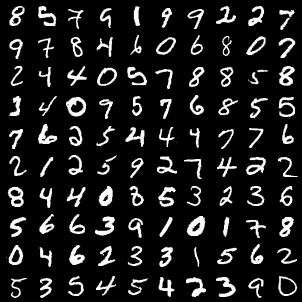

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


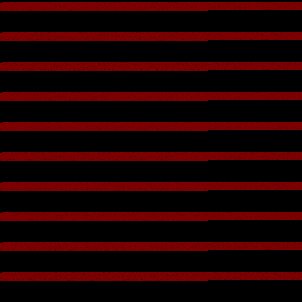

In [26]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [23]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [4/300], Step [200/600], d_loss: 0.4720, g_loss: 2.8334, D(x): 0.88, D(G(z)): 0.19
Epoch [4/300], Step [400/600], d_loss: 0.9565, g_loss: 4.0405, D(x): 0.69, D(G(z)): 0.06
Epoch [4/300], Step [600/600], d_loss: 0.5865, g_loss: 3.4546, D(x): 0.87, D(G(z)): 0.25
Saving fake_images-0005.png
Epoch [5/300], Step [200/600], d_loss: 0.1947, g_loss: 2.6645, D(x): 0.96, D(G(z)): 0.12
Epoch [5/300], Step [400/600], d_loss: 0.0666, g_loss: 5.0054, D(x): 0.98, D(G(z)): 0.05
Epoch [5/300], Step [600/600], d_loss: 0.1041, g_loss: 4.0155, D(x): 0.96, D(G(z)): 0.03
Saving fake_images-0006.png
Epoch [6/300], Step [200/600], d_loss: 0.3116, g_loss: 3.0885, D(x): 0.91, D(G(z)): 0.09
Epoch [6/300], Step [400/600], d_loss: 0.3216, g_loss: 3.0920, D(x): 0.94, D(G(z)): 0.16
Epoch [6/300], Step [600/600], d_loss: 0.1429, g_loss: 3.8584, D(x): 0.99, D(G(z)): 0.12
Saving fake_images-0007.png
Epoch [7/300], Step [200/600], d_loss: 0.3280, g_loss: 4.9091, D(x): 0.88, D(G(z)): 0.04
Epoch [7/300], Step [400/6

KeyboardInterrupt: 

Epoch [0/300], Step [200/600], d_loss: 0.0567, g_loss: 4.0526, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1566, g_loss: 6.0286, D(x): 0.92, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0435, g_loss: 5.4882, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1877, g_loss: 3.5919, D(x): 0.96, D(G(z)): 0.13
Epoch [1/300], Step [400/600], d_loss: 0.0790, g_loss: 4.1593, D(x): 0.98, D(G(z)): 0.05
